## Imgae Reading and Queues and Stacking

> Common representation **shape** of **image tensor**
```bash
(IDX,HEIGHT,WIDTH,CHANNEL)
```
>> **Grey scale**:
```bash
(IDX,HEIGHT,WIDTH,1)
```
>> **RGB**:
```bash
(IDX,HEIGHT,WIDTH,3)
```
>> **CMYK**:(Cyan, Magenta,Yellow and Key)
```bash
(IDX,HEIGHT,WIDTH,4)
```

> **uint** pixels are in range **0-255**

>**float** pixels are in range **0-1**

### Reading image file names into a string

In [1]:
import glob

In [2]:
files_path = 'pics/*.png'
filenames = glob.glob(files_path)
print(filenames)

['pics/computational_graph_regression.png', 'pics/graph3.png', 'pics/graph2.png', 'pics/graph_run=.png']


### Opening image using PIL.Image

In [3]:
from PIL import Image

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=302x266 at 0x7F0D840CB3C8>


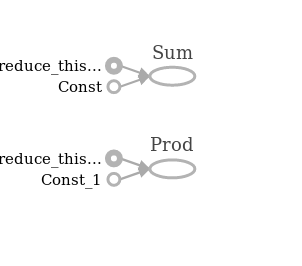

In [50]:
image = Image.open(filenames[2])
print(image)
image # This is a PIL Object

### Get the image into a numpy array

In [5]:
import numpy as np

In [51]:
image_array = np.asarray(image)
print(image_array.shape)

(266, 302, 4)


### Display a numpy array image

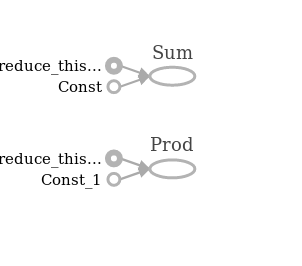

In [7]:
Image.fromarray(image_array,'RGBA') #Here, Image mode should be same as image.mode 

### Adding images to tensorboard

In [8]:
import tensorflow as tf

In [9]:
!rm tensorboard_logs/*

In [56]:
tf.reset_default_graph()
image_tensor = tf.convert_to_tensor(image_array) #returns dtype = unit8
#image_tensor = tf.convert_to_tensor(image) #Same as above. Works on both numpy and PIL objects

print(image_tensor)

#Make it 4D tensor. 4D tensor is required for summary
image_tensor = tf.expand_dims(image_tensor,0)
print(image_tensor)

#Without allow_growth set to true, this program will block the entire gou resource
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    writer = tf.summary.FileWriter('./tensorboard_logs/',sess.graph)
    #Get image summary string and add it to writer
    summary_str = sess.run(tf.summary.image("image_name",image_tensor))
    writer.add_summary(summary_str)
    writer.close()

Tensor("Const:0", shape=(266, 302, 4), dtype=uint8)
Tensor("ExpandDims:0", shape=(1, 266, 302, 4), dtype=uint8)


In [11]:
!tensorboard --logdir=tensorboard_logs/

TensorBoard 1.12.0 at http://c7bb3c6ee95f:6006 (Press CTRL+C to quit)
^C


## Using filename_queue and coordinators for reading image

> Reading image files can be **slow** in python. 

> For efficient reading of media files, which is critical for machine learning applilcations, we use **coordinators**

**Get the list of image names**

In [11]:
files_path = 'pics/*.png'
filenames = glob.glob(files_path)
print(filenames)

['pics/computational_graph_regression.png', 'pics/graph3.png', 'pics/graph2.png', 'pics/graph_run=.png']


**Create queue with image name list**

In [27]:
tf.reset_default_graph()
filename_queue = tf.train.string_input_producer(filenames,seed=0)
print(filename_queue)

```bash
WARNING:tensorflow:From <ipython-input-12-4ee5c4b25f12>:2: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
```

**Create reader with filename_queue**

In [28]:
reader = tf.WholeFileReader()
key,value = reader.read(filename_queue) #Gets the images in the queue one by one
print(key,value)

Tensor("ReaderReadV2:0", shape=(), dtype=string) Tensor("ReaderReadV2:1", shape=(), dtype=string)


```bash
WARNING:tensorflow:From <ipython-input-53-9f6a10a31bd1>:1: WholeFileReader.__init__ (from tensorflow.python.ops.io_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.map(tf.read_file)`.
```

**Decode the image**

> Can handle BMP, GIF, JPEG, or PNG

In [29]:
image_tensor = tf.image.decode_png(value)
print(image_tensor)

Tensor("DecodePng:0", shape=(?, ?, ?), dtype=uint8)


**Run threads**

> **Note**: 

>> Running the **image_tensor** every time, under a session will pull the next image in queue

In [42]:
!rm tensorboard_logs/*

In [43]:
#Without allow_growth set to true, this program will block the entire gou resource
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    writer = tf.summary.FileWriter('./tensorboard_logs/',sess.graph)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
   
    for i in range(len(filenames)):
        
        image_array,summary_str = sess.run([image_tensor,tf.summary.image("image_" + str(i) ,tf.expand_dims(image_tensor,0))])
        print(image_array.shape)
        
        #NOTE: Running this line separately will pull the next image in queue
        #summary_str = sess.run(tf.summary.image("image_" + str(i) ,tf.expand_dims(image_tensor,0)))
        writer.add_summary(summary_str)
        
    writer.close()
    coord.request_stop()
    coord.join(threads)

(887, 524, 4)
(266, 302, 4)
(745, 592, 4)
(274, 720, 4)


In [40]:
!tensorboard --logdir=tensorboard_logs/

TensorBoard 1.12.0 at http://c7bb3c6ee95f:6006 (Press CTRL+C to quit)
^C


```bash
WARNING:tensorflow:From <ipython-input-57-bae544162e8f>:3: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
```

**Wrong way to work with queues**

In [44]:
def run_tf(x):
    #Without allow_growth set to true, this program will block the entire gou resource
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    with tf.Session(config=config) as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess,coord=coord)
        out = sess.run(x)
        coord.request_stop()
        coord.join(threads)
        
        return out      

**Running** the image_tensor in **different sessions** will result in the **same image** being pulled!

In [47]:
image_array = run_tf(image_tensor)
print(image_array.shape)

image_array = run_tf(image_tensor)
print(image_array.shape)

image_array = run_tf(image_tensor)
print(image_array.shape)

##Keeps pulling the same image because the scope of tf.Session is new for every run

(887, 524, 4)
(887, 524, 4)
(887, 524, 4)


### Stacking images

> To convert a **list** of (H,W,C) images to a **4D tensor**, use **tf.stack**
```bash
[(H,W,C), (H,W,C), ...] >> [N,H,W,C]
```
> Used to pass **tensors** in **batch**. tf.summary.image can also handle batch of images 

In [57]:
l = [[1,2],[2,3],[3,4],[4.1,5]]
tf.stack(l)

<tf.Tensor 'stack:0' shape=(4, 2) dtype=float32>